# Parte computacional da questão 1.2


## Questão 1.2.1

Instalando bibliotecas 

In [2]:
%pip install numpy matplotlib plotly pandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Vamos começar determinando algumas bibliotecas que iremos usar, e definindo algumas funções 

In [3]:


import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt


#phi latitude 
#teta longitude
def esfe_cart(phi,teta,r): # Leva das coordenadas esféricas em coordenadas cartesianas 
    x = -r * np.cos(phi) * np.cos(teta)
    y = -r * np.cos(phi) * np.sin(teta)
    z = r * np.sin(phi)
    return x,y,z


def ler_coordenadas(file_name): # Função simples para ler .txt
    with open(file_name, 'r') as f:
        lat =[]
        long =[]
        for line in f:
            
            b,a = line.split()
            lat.append(float(a))
            long.append(float(b))
    return lat, long 

def projecao_mercator(phi,teta): # Realiza a projeção
    return teta, np.log(np.tan(phi/2+np.pi/4))

def calcular_comprimento(curva, r, Fechada = True):
    
    r_bra = curva
    produto_interno = np.sum(r_bra[:, :-1]* r_bra[:, 1:], axis=0)
    #r_bra[:, :-1] percorrer a matriz tirando o ultimo ponto e r_bra[:, 1:] percorrer tirando o primeiro ponto para desalinhar e realizar o produto
    
    if Fechada:
        ultimo_produto = np.sum(r_bra[:, :1] * r_bra[:, -1:],axis=0) # Produto que falta

        produto_interno = np.concatenate(
            [produto_interno, ultimo_produto]
        )
    
    angulos = np.arccos(np.clip(produto_interno/r**2,-1,1))
    # O np.clip evita os erros numéricos de retornar valores fora do intervalo [-1,1] 
    return np.sum(angulos*r)


Em seguida vamos determinar as coordenadas importantes para nosso problema.

In [4]:
#----------------------------------------------------------------------
#----------- Coordenadas ----------------------------------------------
# -----------------------------------------------------------------------


# Lendo as coordenadas da fronteira do mapa do brasil
lat, long = ler_coordenadas("border_main.txt")
lat = np.array(lat)
long = np.array(long)

# Transformando a latitude e longintude em radianos
phi_bra = lat*np.pi/180 
teta_bra = long*np.pi/180

# Criando alguns pontos na suprefície da esfera para visualização 
teta_esf = np.linspace(-np.pi, np.pi, 100)
phi_esf = np.linspace(-np.pi/2, np.pi/2, 50)
teta_esf, phi_esf = np.meshgrid(teta_esf,phi_esf)
r= 1

# Levando para coordenada cartesiana 
x_esf, y_esf, z_esf = esfe_cart( phi_esf,teta_esf, r)
x_bra_f, y_bra_f, z_bra_f = esfe_cart( phi_bra, teta_bra, r)

# Rio de janeiro coordenada 
lat_rj = -22.90
lon_rj = -43.20
phi_rj = lat_rj * np.pi/ 180
teta_rj = lon_rj * np.pi/ 180

# Brisbane Coordenada 
lat_bb = -27.47
lon_bb = 153.02
phi_bb = lat_bb * np.pi/ 180
teta_bb = lon_bb * np.pi/ 180

# Posição em coordenada cartesiana do rio de brisbane 
x_rj_bb, y_rj_bb, z_rj_bb = esfe_cart(np.array([phi_rj, phi_bb]), np.array([teta_rj, teta_bb]), r)

Como a projeção de Mercartor preserva ângulos, a Loxodromia nela é só uma reta. Por isso vamos projetar em mercartor e depois voltar para a esfera.

In [5]:
#----------------------------------------------------------------------
#----------- Laxodromia brisbane ao rio -------------------------------
#----------------------------------------------------------------------

x_merc_rj, y_merc_rj = projecao_mercator(phi_rj, teta_rj) # Coordenada x e y do rio na projeção
x_merc_bb, y_merc_bb = projecao_mercator(phi_bb, teta_bb)  # Coordenada x e y de brisbane na projeção


# Rete entre rio e brisbane.
x_laxo = np.linspace(x_merc_rj, x_merc_bb,100 ) 
y_laxo = np.linspace(y_merc_rj, y_merc_bb,100 )


# Voltar para a esfera
phi_laxo = np.arcsin(np.tanh(y_laxo/r))
teta_laxo = x_laxo/r

x_laxo_esf, y_laxo_esf, z_laxo_esf = esfe_cart(phi_laxo, teta_laxo, r)

Agora vamos determinar a curva geodésica. 
- Determinar, a partir do produto interno, o ângulo entre os vetores **p1** e **p2**, onde **p1**, **p2** são os vetores posição do lugar em relação ao centro da esfera.

- Em seguida, escolher um vetor unitário **u** tal que  
  $ u \cdot p_1 = 1 $, com  
  $ u = \dfrac{p_1}{\lVert p_1 \rVert} = \dfrac{p_1}{R} $.

- Agora vamos usar **p2** para construir **v** tal que  
  $ v \cdot u = 0 $.  
  Tomamos
  $$
  v
  = \frac{p_2 - (p_2 \cdot u)\,u}
         {\lVert p_2 - (p_2 \cdot u)\,u \rVert}.
  $$

- Agora resta parametrizar a curva usando a base **u** e **v**:
  $$
  \text{curva}(t)
  = R \bigl( u \cos t + v \sin t \bigr),
  \qquad
  t \in [0, \theta].
  $$

- O ângulo entre os dois pontos é dado por
  $
  \cos(\theta) = u \cdot v.
  $


In [6]:
#----------------------------------------------------------------------
#----------- Geodésica brisbane ao rio --------------------------------
#----------------------------------------------------------------------

"""Vetores posição do Rio e Brisbane respectivamente. Aqui como a origem está centrada no 
centro do globo, o vetor posição é igual ao vetor pi citado antes"""

r_rj = np.array([x_rj_bb[0], y_rj_bb[0], z_rj_bb[0]])
r_bb = np.array([x_rj_bb[1], y_rj_bb[1], z_rj_bb[1]])

#
u = r_rj / np.linalg.norm(r_rj)
proj = np.dot(r_bb, u) * u
v = r_bb - proj
v = v / np.linalg.norm(v)

Theta = np.arccos(np.dot(u, r_bb))/np.linalg.norm(r_bb)

# Curva
def geodesica(t):
    return u*np.cos(t) + v*np.sin(t)

t_vals = np.linspace(0, Theta, 200)
curve = np.array([geodesica(t) for t in t_vals])

x_geo, y_geo, z_geo = curve[:,0], curve[:,1], curve[:,2]

In [7]:
#----------------------------------------------------------------------
#----------- Plot em 3D -----------------------------------------------
#----------------------------------------------------------------------
# Boa parte desse trecho (quase tudo) é um copía e cola do código dos monitores

fig = go.Figure(data=[
    
    go.Surface(x=x_esf, y=y_esf, z=z_esf, opacity=0.7, colorscale='Blues', showscale=False),
    go.Scatter3d(x= x_bra_f, y= y_bra_f, z= z_bra_f,mode='markers',
                 marker=dict(size=1, color='red')),
    go.Scatter3d(x= x_rj_bb, y= y_rj_bb, z= z_rj_bb,mode='markers',
                 marker=dict(size=5, color='green')),
    go.Scatter3d(x= x_laxo_esf, y= y_laxo_esf, z= z_laxo_esf,mode='lines',
                  line=dict(color='blue', width=6),
        name='Loxodromia'),
    go.Scatter3d(
        x=x_geo, y=y_geo, z=z_geo,
        mode='lines',
        line=dict(color='black', width=6),
        name='Geodésica'
    )
    
])

fig.update_layout(title='Esfera com Plotly', autosize=True,
                  scene=dict(aspectmode='data')) # Mantém a proporção correta

                  # Salvar como HTML interativo
fig.write_html("esfera_plotly.html")
# Para mostrar diretamente no notebook ou em uma nova janela
fig.show()

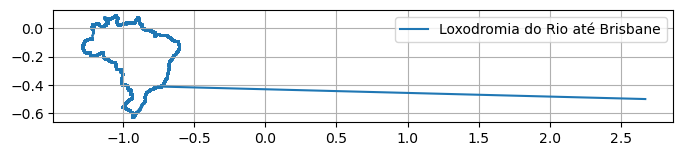

In [8]:
#----------------------------------------------------------------------
#----------- Plot projeção --------------------------------------------
#----------------------------------------------------------------------
#Plotar projeção


#Brasil!!

plt.figure(figsize=(8,6))

plt.plot(x_laxo, y_laxo, label= 'Loxodromia do Rio até Brisbane')

plt.scatter(
    projecao_mercator(phi_bra, teta_bra)[0],
    projecao_mercator(phi_bra, teta_bra)[1],
    s=1
)

plt.gca().set_aspect('equal', adjustable='box')  
plt.grid()
plt.legend()
plt.show()

## Questão 1.2.2

Para calcular a fronteira do Brasil vamos "integrar" os comprimentos de arcos de cada ponto da fronteira. 
Vamos supor que a linha que liga dois pontos próximos no dado é a geodésica. Pois dai basta calcular (pi, pj ) para obter o angulo e multiplicar pelo raio da terra. 

In [9]:
#----------------------------------------------------------------------
#----------- Fronteira do brasil --------------------------------------------
#----------------------------------------------------------------------
r_bra = np.array([x_bra_f, y_bra_f, z_bra_f])

r_terra = 6371 #Km

'''Aqui na função usamos r =1  pois nosso vetor r_gra foi criado apartir de [i_bra_f,...] que tem módulo 1.
 Bataria também multiplica-lo por r da terra e trocar o r que é argumento da função por r_terra'''
comprimento_normalizado = calcular_comprimento(r_bra, r)
# comprimento = calcular_comprimento(r_bra*r_terra, r_terra)
comprimento = comprimento_normalizado*r_terra
print(f"Comprimento da fronteira do Brasil: {comprimento:.2f} Km")




Comprimento da fronteira do Brasil: 24596.32 Km


## Questão 1.2.3

Vamos ler o GPX


In [10]:
import xml.etree.ElementTree as ET
import pandas as pd
from datetime import datetime

# caminho do arquivo
arquivo = "travessia-petropolis-teresopolis.gpx"

# parse do XML
tree = ET.parse(arquivo)
root = tree.getroot()

# namespace do GPX
ns = {"gpx": "http://www.topografix.com/GPX/1/1"}

dados = []

for trkpt in root.findall(".//gpx:trkpt", ns):
    lat = float(trkpt.attrib["lat"])
    lon = float(trkpt.attrib["lon"])
    
    ele = trkpt.find("gpx:ele", ns)
    ele = float(ele.text) if ele is not None else None

    time = trkpt.find("gpx:time", ns)
    time = datetime.fromisoformat(time.text.replace("Z", "")) if time is not None else None

    dados.append({
        "latitude": lat,
        "longitude": lon,
        "elevacao": ele,
        "tempo": time
    })

# cria DataFrame
df = pd.DataFrame(dados)

lat_gps = df["latitude"].to_numpy()
lon_gps = df["longitude"].to_numpy()
t_gps   = df["tempo"].to_numpy()
t_sec = (df["tempo"] - df["tempo"].iloc[0]).dt.total_seconds().to_numpy()

df.head()

,latitude,longitude,elevacao,tempo
0,-22.463015,-43.094122,1050.054,2013-08-21 13:42:34
1,-22.463021,-43.094078,1050.656,2013-08-21 13:42:54
2,-22.462997,-43.094043,1050.311,2013-08-21 13:43:14
3,-22.462980,-43.094015,1050.107,2013-08-21 13:43:34
4,-22.462961,-43.093955,1050.220,2013-08-21 13:43:54


Lido as caracteristicas da curva, vamos agora calcular seu comprimento 

In [11]:
phi_gps = lat_gps*np.pi/180
teta_gps = lon_gps*np.pi/180
r =1
x_gps, y_gps, z_gps = esfe_cart(phi_gps, teta_gps, r=r_terra)
r_curva = np.array([x_gps, y_gps, z_gps])
#print(np.shape(r_curva)
# fazemos a mesma coisa que a questão 1.2.2

comprimento_gps_normalizado = calcular_comprimento(r_curva, r=r_terra, Fechada=False)
comprimento_gps = comprimento_gps_normalizado
print(f'Comprimento do trajeto: {comprimento_gps:.3f} Km')

fig = go.Figure(data=[
    
    
    go.Scatter3d(x= x_gps, y= y_gps, z= z_gps,mode='markers',
                 marker=dict(size=1, color='red')),

    
])

fig.update_layout(title='Esfera com Plotly', autosize=True,
                  scene=dict(aspectmode='data')) # Mantém a proporção correta

                  # Salvar como HTML interativo
fig.write_html("esfera_plotly.html")
# Para mostrar diretamente no notebook ou em uma nova janela
fig.show()

Comprimento do trajeto: 28.729 Km


Vamos calcular o vetor velocidade. A diferenciação de Lanczos usa uma espécie de convolução entre os pontos, da forma.
$$
r'(t) = \frac{1}{\Delta t} \sum_{k =-M}^{M} c_k \cdot r(t + k\Delta t)  
$$

Onde os coeficientes $c_k$ são antisimétricos, ou seja $c_k = - c_{-k}$ para $k$ diferente de 0. Essa soma é uma convolução entre as variáveis discretas. Por isso vamos usar o np.convolve. No nosso caso podemos dizer que $t = t_i$ e denotar da seguinte forma:
$$
r'[i] = \frac{1}{\Delta t} \sum_{k =-M}^{M} c_k \cdot r[i + k] 
$$
Que é a mesma cara de uma convolução, porém ao invez de $i-k$ temos $i+k$. Então por isso devemos inverter o array C de coeficientes.

In [ ]:
def diferentiacao(r,t, C ):
    #C deve ser da forma [-c_n, -c_n-1, ..., c_0, ..., c_n-1, c_n]
    dt = t[1] - t[0]

    v = np.array([
        np.convolve(r[i], C[::-1], mode="valid")
        for i in range(3)
    ]) / dt
    # C[::-1] faz o array ser percorrido ao contrário. e o modo válid evita fazer a convolução para bordas, onde o núcleo não encaixa em r
    return v



#Vamos usar o c_k que vimos em sala.
def C(M):
    div = np.sum([i**2 for i in range(-M, M+1)])
    cidiv = np.array([i for i in range(-M, M+1)])
    return cidiv/div
M=2 
C= C(M)
print(np.shape(r_curva))
v = diferentiacao(r_curva, t_sec, C) #Km/sec

v_norm = np.linalg.norm(v,axis = 0 )  #Km/sec
v_norm = v_norm * 1000 #m/s
integral = np.sum(v_norm*20)
print(f"Velocidade média: {np.mean(v_norm)} m/s")
print(f"Valor do comprimento da curva: {integral} m")






(3, 3911)
Velocidade média: 0.3185924500745764 m/s
Valor do comprimento da curva: 24894.8140488274 m


Note que ignoramos os pontos das bordas. Como temos muitos pontos, acredito que perder 4 pontos, como é nesse caso, não seja tão prejudicial.

Agora vamos plotar a rota em easting-northing

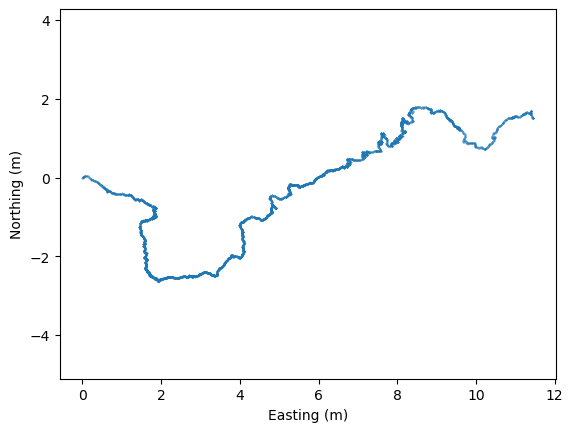

In [23]:


teta_gps_0 = teta_gps[0]
phi_gps_0 = phi_gps[0]


l_teta  = r_terra * np.cos(phi_gps) * (teta_gps - teta_gps_0)
l_phi = r_terra * (phi_gps - phi_gps_0)

plt.figure()
plt.scatter(l_teta, l_phi, s=0.1)
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.axis("equal")
plt.show()


# Parte computacional da Questão 1.3


Calculando o valor de pi usando o método de Monte Carlo.

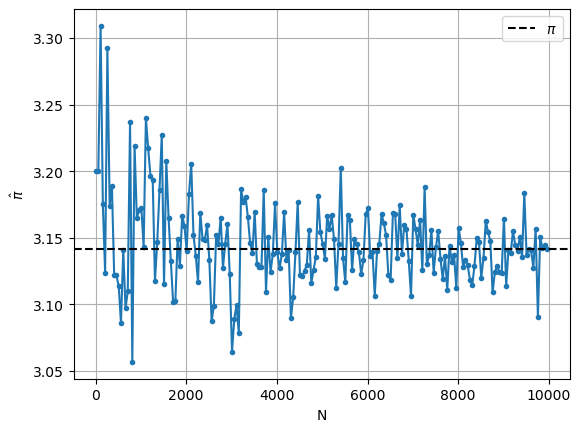

In [14]:
np.random.seed(1002)
def monte_carlo_pi(N):
    x, y = np.random.uniform(0, 2, size= (2, N) )
    mask = (x-1)**2 + (y-1)**2 < 1
    return sum(mask.astype(int))*4/N

# Gráifco em escala normal 

N_vals = np.arange(10, 10000, 50)
pi_vals = [monte_carlo_pi(N) for N in N_vals]

plt.figure()
plt.plot(N_vals, pi_vals, '.-')
plt.axhline(np.pi, color='k', linestyle='--', label=r'$\pi$')
plt.xlabel('N')
plt.ylabel(r'$\hat{\pi}$')
plt.grid()
plt.legend()
plt.show()




Agora vamos olhar o erro em escala logaritima e ralizar um ajuste de curva para observar a cara em que o erro cai.

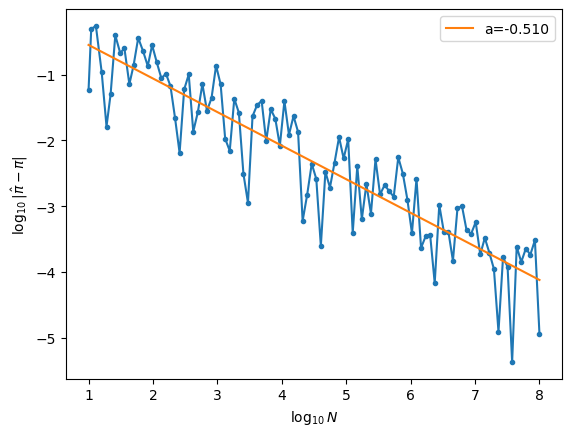

In [15]:
np.random.seed(1002)
# espaço logaritimo
N_vals = np.logspace(1,8, 100, dtype= int)
#print(len(N_vals), N_vals)

erro = np.abs(np.array([monte_carlo_pi(N) for N in N_vals])- np.pi)

#evitar os erros iguais a 0
index_dif_0 = erro > 0
log_N = np.log10(N_vals[index_dif_0])
log_erro = np.log10(erro[index_dif_0])

cof = np.polyfit(log_N, log_erro, 1)
a, b = cof

# curva ajustada
ajuste = b + log_N*a

plt.figure()
plt.plot(log_N, log_erro, '.-')
plt.plot(log_N, ajuste, '-', label = f"a={a:.3f}" )
plt.xlabel(r'$\log_{10} N$')
plt.ylabel(r'$\log_{10}|\hat{\pi} - \pi|$')

plt.legend()



plt.show()


Agora vamos resolver os problemas PIP. Em nosso código vamos estabelecer as condições de cruzamento:
Condições


1. $y$ deve está entre $y_i$ e $y_j$ se não é certeza que não cruza  
   Vamos usar um xor para determinar isso. Ou $y > y_i$ ou $y > y_j$.  

2. $x_{int}$ sendo o pornto de intersecção com a aresta deve ser maior que $x$.  
   Como pela condição anterior $y_i \neq y_j$, podemos escrever  

   $$
   \frac{x_{int} - x_i}{(\{y_{int} = y\}) - y_j}
   =
   \frac{x_i - x_j}{y_i - y_j}
   $$

   Daí temos que:  

   $$
   x_i + (\{y_{int} = y\} - y_j)\frac{x_i - x_j}{y_j - y_i}
   =
   x_{int} > x
   $$

In [16]:

"""
poligono shape
| x_1 y_1 |
| x_2 y_2 |
| x_3 y_3 |
   ....    
[[x,x,x,...][y,y,y...]]
(2,N)

"""


def solve_pip_tracado(r, poly):
   y = r[1] #(N,)
   y_poly_i = poly[1]
   y_poly_j = np.roll(y_poly_i, -1) 
   
   # Condicoes 
   # 1. y deve está entre y_i e y_j se não é certeza que não cruza
   # Vamos usar um xor para determinar isso. Ou y > y_i ou y > y_j. 
   # 2. x_int sendo o pornto de intersecção com a aresta deve ser maior que x. Como pela condição anterior y_i != y_j
   # podemos escrever (x_int - x_i)/({y_int=y} - y_j ) = (x_i - x_j)/(y_j - y_i)
   # Daí temos que: x_i + ({y_int=y} - y_j )*(x_i - x_j)/(y_j - y_i) = x_int > x
   condicao_1 = (y[:,None] > y_poly_i[None,:]) != (y[:,None] > y_poly_j[None,:]) # Usa esse None para mudar o shape e fazer uma espécie de "Multiplicação"
   x = r[0]
   x_poly_i = poly[0]
   x_poly_j = np.roll(x_poly_i, -1)

   #print(condicao_1)
   x_int = x_poly_i[None,:] + (y[:,None] - y_poly_i[None,:]) * \
        (x_poly_j[None,:] - x_poly_i[None,:]) / (y_poly_j[None,:] - y_poly_i[None,:])

   condicao_2 = x[:,None] < x_int
   #print(condicao_2)

   ncruazmento =np.sum(condicao_1 & condicao_2,axis=1) #deve ter shape (N,) 
   #print(ncruazmento)
   #impar -> dentro | par ->fora 

   """
    Perceba que no código existe a possibilidade de dividir por zero na condição 2, isso não importa, pois caso
    ocorra a condição 1 vai garantir que seja falso.
    """
   return ncruazmento % 2 == 1



#Teste
poly = np.array([
    [0, 1, 1, 0],  # x
    [0, 0, 1, 1]   # y
])

r_pont = np.array([
    [0.5, 1.5, 0.2, 0.72], # x
    [0.5, 0.5, 0.9, 0.1]   # y
])
print(sum(solve_pip_tracado(r=r_pont, poly=poly)))



3


/tmp/ipykernel_15606/2847198328.py:30: RuntimeWarning:

divide by zero encountered in divide



Agora vamos usar o método de Monte Carlo e o pip para estimar a área do Brasil

Separar a menor região $\Delta \phi \times \Delta \theta$

In [17]:
min_phi = np.min(phi_bra)
max_phi = np.max(phi_bra)
min_teta = np.min(teta_bra)
max_teta = np.max(teta_bra)


Aqui vamos sortear os pontos de forma uniforme na esfera, sortiando $z$ ~ Unif($z_{min}$, $z_{max}$ ) e $\theta$ ~ Unif($\theta_{min}$, $\theta_{max}$). E por fim usar o método PIP para determinar quantos pontos foram sortiados dentro da área do Brasil.

In [18]:
z_min = r*np.sin(min_phi)
z_max = r*np.sin(max_phi)
np.random.seed(1004)

N_pontos =50000
z_area_brasil = np.random.uniform(z_min, z_max, N_pontos)
phi_area_brasil = np.arcsin(z_area_brasil/r) 
teta_area_brasil = np.random.uniform(min_teta,max_teta, N_pontos)

poly = np.array([teta_bra,phi_bra])
pontos = np.array([teta_area_brasil, phi_area_brasil])

pontos_dentro = sum(solve_pip_tracado(pontos, poly=poly))

area_deltaphi_delta_teta = r**2 * (max_teta- min_teta) * ( np.sin(max_phi) - np.sin(min_phi))

#print(area_deltaphi_delta_teta)
area_brasil = area_deltaphi_delta_teta * pontos_dentro/N_pontos * r_terra**2
print(f'A área do Brasil é: {area_brasil} km')


/tmp/ipykernel_15606/2847198328.py:30: RuntimeWarning:

divide by zero encountered in divide

/tmp/ipykernel_15606/2847198328.py:30: RuntimeWarning:

invalid value encountered in divide



A área do Brasil é: 8489215.611725966 km


In [19]:
'''a=np.array([[1,2,3],[4,5,3]])
np.roll(a,-1, axis=1)
y = np.array([1,5,2])
y[:,None] # (n,1)
z = np.array([1,2,4,5])
z[None, :]
k =y[:,None] * z[None,:] / (y[:,None] * z[None,:])
k = z[:,None] != y[None,:] 
print(np.shape(k))
print(k)
np.sum(k, axis =1)'''

'a=np.array([[1,2,3],[4,5,3]])\nnp.roll(a,-1, axis=1)\ny = np.array([1,5,2])\ny[:,None] # (n,1)\nz = np.array([1,2,4,5])\nz[None, :]\nk =y[:,None] * z[None,:] / (y[:,None] * z[None,:])\nk = z[:,None] != y[None,:] \nprint(np.shape(k))\nprint(k)\nnp.sum(k, axis =1)'